## RAG EVALUATION METRICS COMPARISON

- DEEPEVAL
- RAGAS
- TRULENS
- ARIZE PHOENIX

### REQUIREMENTS

In [1]:
%pip  install langchain langchain-community langchain-groq langchain-huggingface \
    sentence-transformers faiss-cpu pypdf bert-score scikit-learn python-dotenv plotly

%pip  install deepeval trulens giskard ragas datasets
%pip  install trulens-core trulens-providers-openai
%pip  install trulens-dashboard
%pip  install trulens-apps-langgraph
%pip install rapidfuzz



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note

### IMPORTS

In [37]:
import os, re
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import score as bert_score
from sklearn.metrics.pairwise import cosine_similarity
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from openai import OpenAIError
from groq import Groq
import os
from dotenv import load_dotenv


In [5]:
DEEPEVAL = TRULENS = GISKARD = RAGAS = False

try:
    import deepeval
    from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric, ContextualRelevancyMetric, ContextualPrecisionMetric, ContextualRecallMetric
    from deepeval.test_case import LLMTestCase
    DEEPEVAL = True
except: pass

try:
    import trulens
    from trulens.feedback import GroundTruthAgreement
    TRULENS = True
except: pass

try:
    import giskard
    GISKARD = True
except: pass

try:
    from ragas.llms import LangchainLLMWrapper
    from ragas.embeddings import LangchainEmbeddingsWrapper
    from ragas.evaluation import evaluate
    from ragas.metrics import ContextPrecision, ContextRecall, Faithfulness
    from datasets import Dataset
    RAGAS = True
except: pass

### FILE LOADING-CHUNKING-EMBEDDING

##### SETUP

In [ ]:
# from google.colab import userdata

# OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
# GROQ_KEY = userdata.get("GROQ_KEY")
# os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
# os.environ["GROQ_KEY"] = GROQ_KEY

import os
from dotenv import load_dotenv

load_dotenv()

# Fetch keys
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
GROQ_KEY = os.getenv("GROQ_KEY")

# Set them into environment variables (optional, if other libs need them)
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["GROQ_KEY"] = GROQ_KEY

In [ ]:
PDF_PATH      = "/Users/ammuuu/dumbshit/genai/10_LangChain/1_RAG_EVAL/sample.pdf"
CSV_PATH      = "/Users/ammuuu/dumbshit/genai/10_LangChain/1_RAG_EVAL/qa.csv"
MODEL_NAME    = "llama3-8b-8192"
TOP_K         = 3

client = Groq(api_key=GROQ_KEY)

loader   = PyPDFLoader(PDF_PATH)
pages    = loader.load()
splitter = TokenTextSplitter(chunk_size=800, chunk_overlap=150)
chunks   = splitter.split_documents(pages)

hf_embeddings  = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore    = FAISS.from_documents(chunks, hf_embeddings)
retriever      = vectorstore.as_retriever(search_kwargs={"k": TOP_K})

qa_df = pd.read_csv(CSV_PATH).fillna("")
assert all(col in qa_df for col in ["Question", "Reference Answer"])

def retrieve_contexts(question: str) -> list[str]:
    docs = retriever.invoke(question)
    return [doc.page_content for doc in docs]

qa_df["contexts"] = qa_df["Question"].apply(retrieve_contexts)

def generate_answer(question, contexts):
    context_block = "\n\n".join(f"[{i+1}] {txt}" for i, txt in enumerate(contexts))
    prompt = (
        "You are an expert factual assistant. Answer using ONLY the provided context; "
        f"{context_block}\n\nQuestion: {question}\nAnswer:"
    )
    resp = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0
    )
    return resp.choices[0].message.content.strip()

qa_df["answer"] = qa_df.apply(lambda row: generate_answer(row["Question"], row["contexts"]), axis=1)

/Users/ammuuu/dumbshit/genai/10_LangChain/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:

# Create a DataFrame with chunk indices and contents
chunks_df = pd.DataFrame({
    "chunk_id": list(range(len(chunks))),
    "chunk_text": [chunk.page_content for chunk in chunks]
})

# Save to CSV
chunks_df.to_csv("pdf_chunks.csv", index=False)

print("All chunks saved to pdf_chunks.csv")


All chunks saved to pdf_chunks.csv


In [ ]:
def parse_relevant_chunk_ids(val):
    if pd.isnull(val) or val == "":
        return set()
    # Convert to set of ints
    return {int(x) for x in str(val).replace(',', ' ').split() if x.strip().isdigit()}

# Add a parsed relevant chunk ids column if not already present
if 'Relevant Chunk IDs' in qa_df.columns:
    qa_df['relevant_chunk_ids'] = qa_df['Relevant Chunk IDs'].apply(parse_relevant_chunk_ids)
else:
    qa_df['relevant_chunk_ids'] = [set() for _ in range(len(qa_df))]

# Now get retrieved chunk IDs per question, by matching retrieved context against chunks:
retrieved_chunk_ids_list = []

for idx, row in qa_df.iterrows():
    retrieved = set()
    retrieved_contexts = row["contexts"]
    for ctx in retrieved_contexts:
        for i, chunk in enumerate(chunks):
            if ctx.strip()[:200] in chunk.page_content[:250]:
                retrieved.add(i)
    retrieved_chunk_ids_list.append(retrieved)

qa_df["retrieved_chunk_ids"] = retrieved_chunk_ids_list

# Now select and rename columns for display:
display_df = qa_df[["Question", "relevant_chunk_ids", "retrieved_chunk_ids", "Reference Answer", "answer"]].copy()

display_df.rename(columns={
    "relevant_chunk_ids": "Relevant Chunk IDs",
    "retrieved_chunk_ids": "Retrieved Chunk IDs",
    "answer": "Generated Answer",
    "Reference Answer": "Reference Answer",
    "Question": "Question"
}, inplace=True)

print(display_df)

try:
    from IPython.display import display
    display(display_df)
except ImportError:
    pass


                                            Question Relevant Chunk IDs  \
0  What are the key challenges in large-scale sol...         {49, 3, 7}   
1  How does the proposed plant integrate with the...           {16, 15}   
2  What is the estimated land area required for t...        {17, 18, 5}   
3  How is environmental impact addressed in the I...        {20, 6, 22}   
4  What are the main areas and planned deliverabl...       {49, 50, 51}   

  Retrieved Chunk IDs                                   Reference Answer  \
0          {3, 54, 7}  Key challenges include high cost of technology...   
1         {8, 16, 20}  The solar plant is modular, with each 50 kW st...   
2        {16, 17, 20}  Approximately 10,000 m² is needed for the PV p...   
3         {40, 20, 6}  Main concerns are proper disposal and recyclin...   
4         {49, 3, 33}  Focused on developing solid oxide fuel cells (...   

                                    Generated Answer  
0  According to the provided context,

,Question,Relevant Chunk IDs,Retrieved Chunk IDs,Reference Answer,Generated Answer
0,What are the key challenges in large-scale sol...,"{49, 3, 7}","{3, 54, 7}",Key challenges include high cost of technology...,"According to the provided context, the key cha..."
1,How does the proposed plant integrate with the...,"{16, 15}","{8, 16, 20}","The solar plant is modular, with each 50 kW st...","According to the provided context, the propose..."
2,What is the estimated land area required for t...,"{17, 18, 5}","{16, 17, 20}","Approximately 10,000 m² is needed for the PV p...","According to the provided context, the estimat..."
3,How is environmental impact addressed in the I...,"{20, 6, 22}","{40, 20, 6}",Main concerns are proper disposal and recyclin...,"According to the provided context, the main en..."
4,What are the main areas and planned deliverabl...,"{49, 50, 51}","{49, 3, 33}",Focused on developing solid oxide fuel cells (...,"According to the provided context, the main ar..."


### MODERN FRAMEWORKS

#### DEEPEVAL

In [ ]:
from deepeval.metrics import (
    AnswerRelevancyMetric, FaithfulnessMetric, ContextualRelevancyMetric,
    ContextualPrecisionMetric, ContextualRecallMetric, ToxicityMetric,
    HallucinationMetric
)
from deepeval.test_case import LLMTestCase

def evaluate_with_deepeval(q, a, ctx_list, ref):
    case = LLMTestCase(
        input=q,
        actual_output=a,
        expected_output=ref,
        retrieval_context=ctx_list,
        context=ctx_list
    )
    metrics = [
        AnswerRelevancyMetric(),
        FaithfulnessMetric(),
        ContextualRelevancyMetric(),
        ContextualPrecisionMetric(),
        ContextualRecallMetric(),
        ToxicityMetric(),
        HallucinationMetric()
    ]
    results = {}
    for m in metrics:
        m.measure(case)
        results[m.__class__.__name__] = getattr(m, "score", None)
    return results



In [ ]:
import time

deepeval_rows = []

for idx, row in qa_df.iterrows():
    q = row["Question"]
    ref = str(row["Reference Answer"]).strip()
    gt_chunks = str(row["Relevant Chunk IDs"])
    # Parse relevant chunk IDs as integers
    relevant_ids = [int(i.strip()) for i in re.split(r"[,\s]+", gt_chunks) if i.strip().isdigit()]
    # Retrieve top docs for the question
    docs = retriever.invoke(q)
    # Collect content from up to 5 docs
    context_list = [d.page_content[:1500] for d in docs[:5]]
    context = "\n\n".join(context_list)
    # Initialize model and build prompt
    model = ChatGroq(groq_api_key=os.environ["GROQ_KEY"], model_name="llama3-8b-8192")
    prompt = f"Use only this context to answer:\n\n{context}\n\nQ: {q}\nA:"
    answer = model.invoke(prompt).content.strip()
    # Evaluate answer with DeepEval
    try:
        dr = evaluate_with_deepeval(q, answer, context_list, ref)
    except Exception as e:
        print(f"Evaluation failed for Q#{idx+1}: {e}")
        dr = {"Q#": idx+1, "Error": str(e)}

    dr["Q#"] = idx + 1
    deepeval_rows.append(dr)

    time.sleep(5) # To avoid rate limits

deepeval_df = pd.DataFrame(deepeval_rows).set_index("Q#")
# Display formatted DataFrame
display(deepeval_df.style.format("{:.3f}"))

import matplotlib.pyplot as plt

for col in deepeval_df.columns:
    deepeval_df.plot.bar(y=col, legend=False, title=f"DeepEval: {col}")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Question #")
    plt.show()



Output()

2025-08-06 15:19:14,463 pid:71553 MainThread root         ERROR    OpenAI Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}} Retrying: 1 time(s)...


2025-08-06 15:19:18,594 pid:71553 MainThread root         ERROR    OpenAI Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}} Retrying: 2 time(s)...


2025-08-06 15:19:23,662 pid:71553 MainThread root         ERROR    OpenAI Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}} Retrying: 3 time(s)...


2025-08-06 15:19:30,790 pid:71553 MainThread root         ERROR    OpenAI Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}} Retrying: 4 time(s)...


2025-08-06 15:19:41,741 pid:71553 MainThread root         ERROR    OpenAI Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}} Retrying: 5 time(s)...


KeyboardInterrupt: 

2025-08-06 15:19:54,058 pid:71553 MainThread root         ERROR    OpenAI Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}} Retrying: 6 time(s)...
2025-08-06 15:20:06,412 pid:71553 MainThread root         ERROR    OpenAI Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}} Retrying: 7 time(s)...
2025-08-06 15:20:19,653 pid:71553 MainThread root         ERROR    OpenAI Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check yo

#### RAGAS

In [ ]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.evaluation import evaluate
from ragas.metrics import ContextPrecision, ContextRecall, Faithfulness
from datasets import Dataset

from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
    answer_correctness
)
# Prepare Dataset from your QA DataFrame
ragas_dataset = Dataset.from_dict({
    "question": qa_df["Question"].tolist(),
    "contexts": qa_df["contexts"].tolist(),
    "answer": qa_df["answer"].tolist(),
    "ground_truth": qa_df["Reference Answer"].tolist()
})
# Choose metrics to evaluate
metrics = [
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
    answer_correctness
]
# Run RAGAS evaluation
results = evaluate(ragas_dataset, metrics=metrics)
results_df = results.to_pandas()

metric_df = results_df.select_dtypes(include="float")

rename_map = {
    "context_precision": "ContextualPrecisionMetric",
    "context_recall": "ContextualRecallMetric",
    "faithfulness": "FaithfulnessMetric",
    "answer_relevancy": "AnswerRelevancyMetric",
    "answer_correctness": "AnswerCorrectnessMetric"
}
metric_df = metric_df.rename(columns=rename_map)

metric_df.insert(0, "Q#", range(1, len(metric_df) + 1))

pd.set_option("display.float_format", lambda x: f"{x:.3f}")

print("\nRAGAS Evaluation Results :")
print(metric_df.to_string(index=False))

avg_scores = metric_df.iloc[:, 1:].mean()

plt.figure(figsize=(8, 4))
avg_scores.plot.bar(color=sns.color_palette("tab10"))
plt.ylim(0, 1)
plt.title("Average RAGAS Metric Scores")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

2025-08-06 15:21:48,161 pid:71553 MainThread ragas.executor ERROR    Exception raised in Job[7]: RateLimitError(Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}})
2025-08-06 15:22:20,398 pid:71553 MainThread ragas.executor ERROR    Exception raised in Job[13]: RateLimitError(Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}})


KeyboardInterrupt: 

2025-08-06 15:22:25,149 pid:71553 MainThread ragas.executor ERROR    Exception raised in Job[3]: RateLimitError(Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}})
2025-08-06 15:22:25,150 pid:71553 MainThread ragas.executor ERROR    Exception raised in Job[18]: AssertionError(LLM is not set)
2025-08-06 15:22:25,152 pid:71553 MainThread ragas.executor ERROR    Exception raised in Job[19]: AssertionError(LLM must be set)
2025-08-06 15:22:25,156 pid:71553 MainThread ragas.executor ERROR    Exception raised in Job[20]: AssertionError(LLM is not set)
2025-08-06 15:22:25,158 pid:71553 MainThread ragas.executor ERROR    Exception raised in Job[21]: AssertionError(set LLM before use)
2025-08-06 15:22:25,159 pid:71553 MainThread ragas.exec

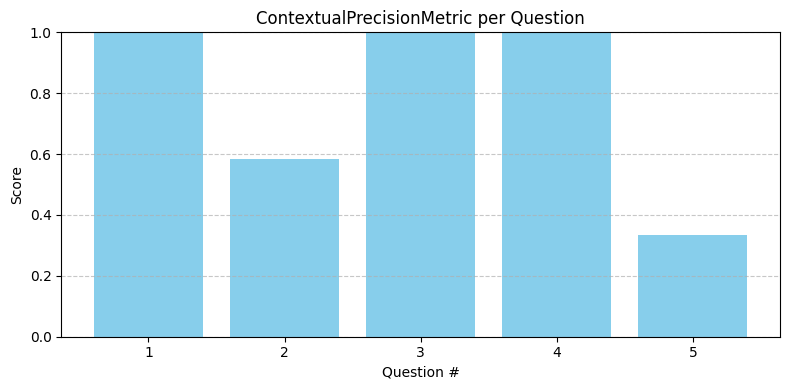

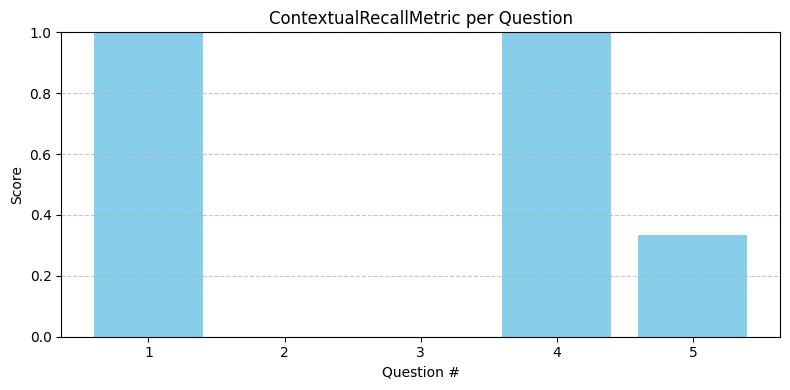

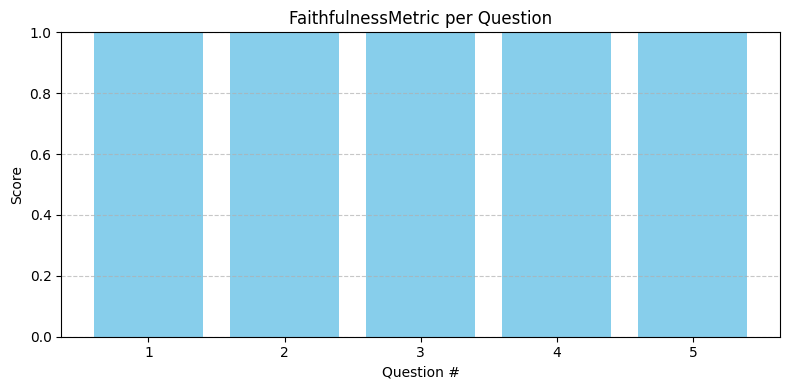

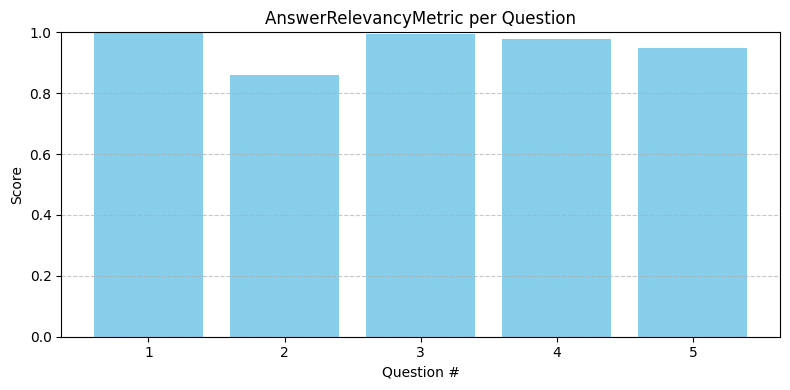

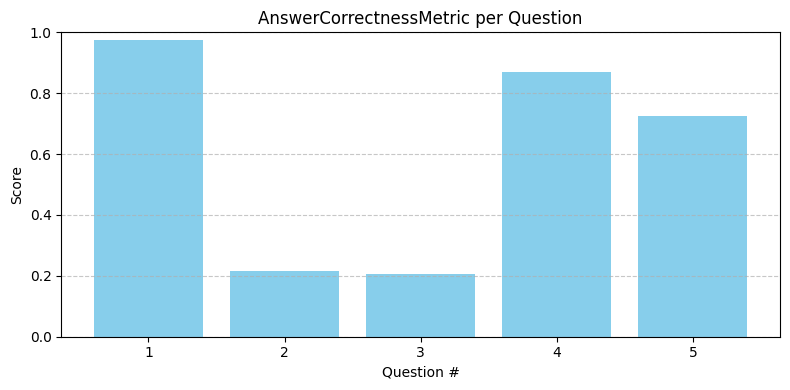

In [ ]:
import matplotlib.pyplot as plt

for metric in metric_df.columns[1:]:
    plt.figure(figsize=(8, 4))
    plt.bar(metric_df["Q#"], metric_df[metric], color="skyblue")
    plt.title(f"{metric} per Question")
    plt.xlabel("Question #")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(metric_df["Q#"])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


#### TRULENS

In [45]:
from dotenv import load_dotenv
import os
from trulens.providers.openai import OpenAI as TruOpenAI
from trulens.core.feedback import Feedback
import pandas as pd
from tqdm import tqdm

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


tru_provider = TruOpenAI(model_engine="gpt-4o") 

# Feedback functions
f_context_relevance = Feedback(tru_provider.context_relevance)
f_groundedness = Feedback(tru_provider.groundedness_measure_with_cot_reasons)
f_answer_relevance = Feedback(tru_provider.relevance)
f_conciseness = Feedback(tru_provider.conciseness)
f_helpfulness = Feedback(tru_provider.helpfulness)

# Truncate context block for evaluation if needed
MAX_CONTEXT_CHARS = 3000

# Create context_block column if not already
qa_df["context_block"] = qa_df["contexts"].apply(lambda ctx_list: "\n\n".join(ctx_list))

# Evaluation
print("Evaluating answers with TruLens metrics...")

results = []
for idx, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
    question = row["Question"]
    answer = row["answer"]
    context_block = row["context_block"][:MAX_CONTEXT_CHARS]  # Truncate for safety

    print(f"\n--- Evaluating Q#{idx+1} ---")
    print(f"Question: {question}")
    print(f"Answer: {answer[:200]}")
    print(f"Context (first 200 chars): {context_block[:200]}\n")

    try:
        context_score = f_context_relevance(question=question, context=context_block)
    except Exception as e:
        print(f"[!] Context Relevance error: {e}")
        context_score = -1

    try:
        groundedness_result = f_groundedness(source=context_block, statement=answer)
        if isinstance(groundedness_result, tuple):
            groundedness_score, groundedness_meta = groundedness_result
        else:
            groundedness_score = groundedness_result
            groundedness_meta = {"reasons": "N/A"}
    except Exception as e:
        print(f"[!] Groundedness error: {e}")
        groundedness_score = -1
        groundedness_meta = {"reasons": str(e)}

    try:
        answer_relevance_score = f_answer_relevance(prompt=question, response=answer)
    except Exception as e:
        print(f"[!] Answer Relevance error: {e}")
        answer_relevance_score = -1

    try:
        conciseness_score = f_conciseness(text=answer)
    except Exception as e:
        print(f"[!] Conciseness error: {e}")
        conciseness_score = -1

    try:
        helpfulness_score = f_helpfulness(text=answer)
    except Exception as e:
        print(f"[!] Helpfulness error: {e}")
        helpfulness_score = -1

    results.append({
        "Q#": idx + 1,
        "Question": question,
        "Answer": answer,
        "ContextRelevance": context_score,
        "Groundedness": groundedness_score,
        "GroundednessReasons": groundedness_meta.get("reasons", "N/A"),
        "AnswerRelevance": answer_relevance_score,
        "Conciseness": conciseness_score,
        "Helpfulness": helpfulness_score
    })

# Final results DataFrame
results_df = pd.DataFrame(results)

# Print summary
pd.set_option('display.max_colwidth', 100)
print("\n=== TruLens Evaluation Results (Summary) ===\n")
print(results_df[[
    "Q#", "ContextRelevance", "Groundedness", "AnswerRelevance",
    "Conciseness", "Helpfulness"
]])


Evaluating answers with TruLens metrics...


  0%|          | 0/5 [00:00<?, ?it/s]


--- Evaluating Q#1 ---
Question: What are the key challenges in large-scale solar energy utilization?
Answer: According to the provided context, the key challenges in large-scale solar energy utilization are:

1. Cost of technology
2. Energy storage
3. Distribution of solar power
4. Daily/seasonal variability
Context (first 200 chars): 8 
 
 
2. INTRODUCTION  
 
With the increasing demand of energy via greener methods and the gradual depletion of 
fossil fuels, solar energy conversion has regained the spotlight of the global energy 

2025-08-06 17:18:15,595 pid:71553 MainThread trulens.core.feedback.endpoint ERROR    OpenAIEndpoint request failed <class 'openai.RateLimitError'>=Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}. 

/Users/ammuuu/dumbshit/genai/10_LangChain/venv/lib/python3.10/site-packages/trulens/feedback/llm_provider.py:1966: UserWarning: Failed to process and remove trivial statements. Proceeding with all statements.
  warnings.warn(


2025-08-06 17:18:34,875 pid:71553 ThreadPoolExecutor-20_0 trulens.core.feedback.endpoint ERROR    OpenAIEndpoint request failed <class 'openai.RateLimitError'>=Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}. Retries remaining=3.
2025-08-06 17:18:35,929 pid:71553 ThreadPoolExecutor-20_3 trulens.core.feedback.endpoint ERROR    OpenAIEndpoint request failed <class 'openai.RateLimitError'>=Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}. Retries remaining=3.
2025-08-06 17:

  0%|          | 0/5 [00:53<?, ?it/s]


KeyboardInterrupt: 

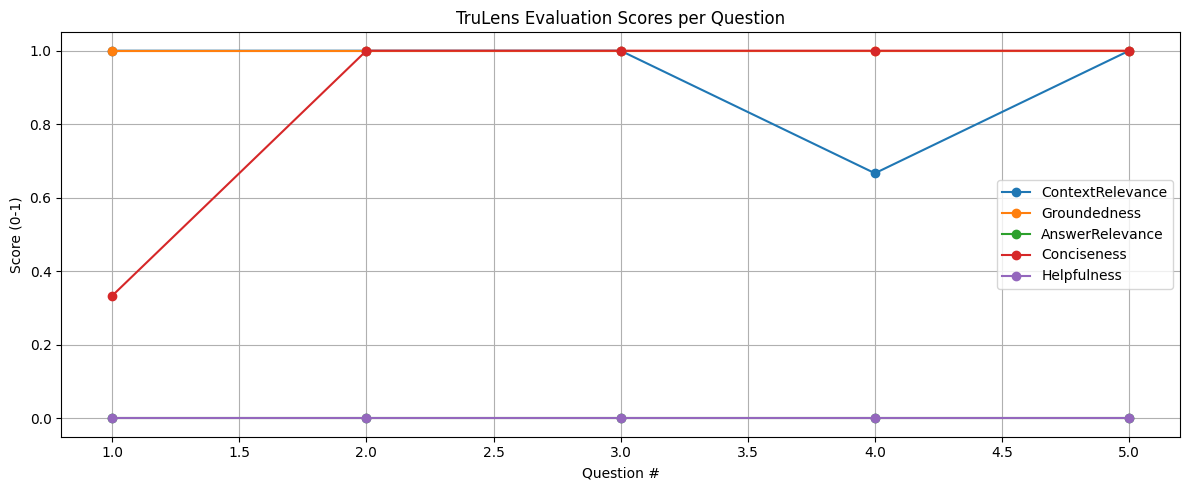

In [ ]:
import matplotlib.pyplot as plt

metrics_to_plot = [
    "ContextRelevance", "Groundedness", "AnswerRelevance",
    "Conciseness", "Helpfulness"
]

plt.figure(figsize=(12, 5))
for metric in metrics_to_plot:
    plt.plot(results_df["Q#"], results_df[metric], marker='o', label=metric)

plt.xlabel("Question #")
plt.ylabel("Score (0-1)")
plt.title("TruLens Evaluation Scores per Question")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### ARIZE PHOENIX

In [ ]:
%pip install "arize-phoenix[llama-index]>=2.0" llama-index>=0.12.48 llama-index-llms-openai>=0.4.7 sentence-transformers>=2.7.0 nest_asyncio>=1.6.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


zsh:1: 0.12.48 not found
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import pandas as pd
import nest_asyncio
import threading

# === Setup Phoenix UI ===
nest_asyncio.apply()

def launch_phoenix():
    os.environ["PHOENIX_PORT"] = "6006"
    import phoenix as px  # Import inside thread to pick up env var cleanly
    px.launch_app()


❗️ The launch_app `port` parameter is deprecated and will be removed in a future release. Use the `PHOENIX_PORT` environment variable instead.


/opt/homebrew/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:142: SAWarning: Skipped unsupported reflection of expression-based index ix_cumulative_llm_token_count_total
  next(self.gen)
/opt/homebrew/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:142: SAWarning: Skipped unsupported reflection of expression-based index ix_latency
  next(self.gen)


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://arize.com/docs/phoenix


In [37]:
# Run Phoenix UI in a background thread so your script can continue
server_thread = threading.Thread(target=launch_phoenix, daemon=True)
server_thread.start()
print("Phoenix server launched at http://localhost:6006")

# === Set Environment Variable for Phoenix Client before importing phoenix ===
os.environ["PHOENIX_URL"] = "http://localhost:6006"

Phoenix server launched at http://localhost:6006
2025-08-06 17:09:02,871 pid:71553 Thread-67 (run) phoenix.session.session WARNING  Existing running Phoenix instance detected! Shutting it down and starting a new instance...


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://arize.com/docs/phoenix


In [ ]:
# Import phoenix and SpanEvaluations after env var set
import phoenix as px
from phoenix.trace import SpanEvaluations

# === OpenTelemetry Registration with BatchSpanProcessor ===
from phoenix.otel import register
from opentelemetry.sdk.trace.export import BatchSpanProcessor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter

exporter = OTLPSpanExporter(endpoint="http://localhost:6006/v1/traces") 
batch_processor = BatchSpanProcessor(exporter)

tracer_provider = register(
    project_name="default",
    endpoint="http://localhost:6006/v1/traces",
    auto_instrument=True,
    set_global_tracer_provider=True,
)

# Add span processor manually
tracer_provider.add_span_processor(batch_processor)

# === Instrument LlamaIndex for automatic tracing ===
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
LlamaIndexInstrumentor().instrument(tracer_provider=tracer_provider)

2025-08-06 17:10:22,040 pid:71553 MainThread opentelemetry.trace WARNING  Overriding of current TracerProvider is not allowed
2025-08-06 17:10:22,055 pid:71553 MainThread opentelemetry.instrumentation.instrumentor WARNING  Attempting to instrument while already instrumented
🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: default
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

2025-08-06 17:10:22,056 pid:71553 MainThread opentelemetry.instrumentation.instrumentor WARNING  Attempting to instrument while already instrumented


In [39]:
# === Load Data ===

qa_df = pd.read_csv(CSV_PATH).fillna("")
expected_cols = ['Question', 'Relevant Chunk IDs', 'Reference Answer']
assert all(col in qa_df.columns for col in expected_cols), f"Your CSV must have columns: {expected_cols}"

# === Chunk PDF and Build Vector Index ===
from llama_index.core.readers import SimpleDirectoryReader
from llama_index.core.indices.vector_store import VectorStoreIndex
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Load PDFs as Documents
docs = SimpleDirectoryReader(input_files=[PDF_PATH]).load_data()

# Chunk the documents
node_parser = SimpleNodeParser(chunk_size=800, chunk_overlap=150)
chunks = node_parser.get_nodes_from_documents(docs)

# Initialize embeddings
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Build vector store index
index = VectorStoreIndex(chunks, embed_model=embed_model)
retriever = index.as_retriever(similarity_top_k=3)


/Users/ammuuu/dumbshit/genai/10_LangChain/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [40]:
# === Initialize LLM for answer generation ===
from llama_index.llms.openai import OpenAI as LlamaOpenAI
llm = LlamaOpenAI(model="gpt-4o", api_key=os.getenv("OPENAI_API_KEY"))

def generate_answer(question, contexts):
    context_block = "\n\n".join(f"[{i+1}] {ctx}" for i, ctx in enumerate(contexts))
    prompt = (
        "You are an expert factual assistant. Answer using ONLY the provided context; "
        "If insufficient, reply 'Insufficient information.'\n\n"
        f"{context_block}\n\nQuestion: {question}\nAnswer:"
    )
    response = llm.complete(prompt)
    return response.text.strip()

def retrieve_contexts(question):
    nodes = retriever.retrieve(question)
    return [node.text for node in nodes]

# === Run Retrieval and Generation while tracing is active ===
qa_df["contexts"] = qa_df["Question"].apply(retrieve_contexts)
qa_df["answer"] = qa_df.apply(lambda row: generate_answer(row["Question"], row["contexts"]), axis=1)

# === Parse relevant chunk IDs for evaluation ===
def parse_relevant_chunk_ids(s):
    if pd.isnull(s) or s == "":
        return set()
    return {int(x) for x in str(s).replace(',', ' ').split() if x.strip().isdigit()}

qa_df['relevant_chunk_ids'] = qa_df['Relevant Chunk IDs'].apply(parse_relevant_chunk_ids)

2025-08-06 17:11:33,453 pid:71553 MainThread llama_index.llms.openai.utils WARNING  Retrying llama_index.llms.openai.base.OpenAI._chat in 0.7053454098720393 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}.
2025-08-06 17:11:38,525 pid:71553 MainThread llama_index.llms.openai.utils WARNING  Retrying llama_index.llms.openai.base.OpenAI._chat in 0.20817169763234555 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficie

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
# === Prepare nDCG@3 and precision@3 evaluation metrics ===
ndcg_rows = []
precision_rows = []

for idx, row in qa_df.iterrows():
    relevant = row['relevant_chunk_ids']
    retrieved = set()

    # Loose matching of retrieved contexts to chunk indices
    for context in row["contexts"]:
        for i, chunk in enumerate(chunks):
            if context.strip()[:100] in chunk.text[:150]:
                retrieved.add(i)

    intersection = retrieved & relevant
    ndcg_val = 1 if intersection else 0
    precision_val = len(intersection) / max(len(retrieved), 1)

    ndcg_rows.append({"question_id": idx, "eval_name": "ndcg@3", "score": ndcg_val})
    precision_rows.append({"question_id": idx, "eval_name": "precision@3", "score": precision_val})

# Create evaluation DataFrames and add required index
span_ids = [f"span-{i}" for i in range(len(ndcg_rows))]

In [ ]:
print(client._client.base_url)


http://127.0.0.1:6006


### TRADITIONAL METRICS

In [19]:
def recall_at_k(retrieved, relevant, k):
    return len(set(retrieved[:k]) & set(relevant)) / max(len(set(relevant)), 1)
def precision_at_k(retrieved, relevant, k):
    return len(set(retrieved[:k]) & set(relevant)) / max(k, 1)
def mrr(retrieved, relevant):
    for i, r in enumerate(retrieved, 1):
        if r in relevant: return 1/i
    return 0.0
def answer_relevance(q, a):
    qv, av = hf_embeddings.embed_query(q), hf_embeddings.embed_query(a)
    return float(cosine_similarity([qv],[av])[0][0])
def bertscore(a, ref):
    P, R, F1 = bert_score([a], [ref], lang="en", model_type="bert-base-uncased")
    return float(P[0]), float(R[0]), float(F1[0])


In [20]:
llm = ChatGroq(groq_api_key=GROQ_KEY, model_name="llama3-8b-8192")
k = 3

In [35]:
traditional_rows = []

for idx, row in qa_df.iterrows():
    q = row["Question"]
    gt_chunks = str(row["Relevant Chunk IDs"])
    ref = str(row["Reference Answer"]).strip()
    relevant_ids = [int(i.strip()) for i in re.split(r"[,\s]+", gt_chunks) if i.strip().isdigit()]
    docs = retriever.invoke(q)
    retrieved_ids, retrieved_docs = [], []
    for doc in docs:
        match = [i for i, c in enumerate(chunks) if c.page_content == doc.page_content]
        if match:
            retrieved_ids.append(match[0])
            retrieved_docs.append(doc)
    prompt = f"Use only this context to answer:\n\n{chr(10).join([d.page_content for d in retrieved_docs])}\n\nQ: {q}\nA:"
    model_resp = llm.invoke(prompt)
    answer = model_resp.content if hasattr(model_resp, "content") else str(model_resp)
    answer = answer.strip()
    r_at_k = recall_at_k(retrieved_ids, relevant_ids, k)
    p_at_k = precision_at_k(retrieved_ids, relevant_ids, k)
    mrr_val = mrr(retrieved_ids, relevant_ids)
    cos_sim = answer_relevance(q, answer)
    bertP, bertR, bertF1 = bertscore(answer, ref) if ref else (None, None, None)
    traditional_rows.append({
        "Q#": idx+1, "Recall@k": r_at_k, "Precision@k": p_at_k, "MRR": mrr_val,
        "Cosine Similarity (Q↔A)": cos_sim, "BERTScore (P)": bertP, "BERTScore (R)": bertR, "BERTScore (F1)": bertF1
    })
traditional_df = pd.DataFrame(traditional_rows)
display(traditional_df.style.format("{:.3f}"))


/Users/ammuuu/dumbshit/genai/10_LangChain/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/ammuuu/dumbshit/genai/10_LangChain/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/ammuuu/dumbshit/genai/10_LangChain/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/ammuuu/dumbshit/genai/10_LangChain/v

,Q#,Recall@k,Precision@k,MRR,Cosine Similarity (Q↔A),BERTScore (P),BERTScore (R),BERTScore (F1)
0,1.000,0.667,0.667,1.000,0.901,0.605,0.645,0.624
1,2.000,0.500,0.333,0.333,0.565,0.510,0.518,0.514
2,3.000,0.333,0.333,1.000,0.901,0.589,0.648,0.617
3,4.000,0.667,0.667,1.000,0.422,0.741,0.594,0.660
4,5.000,0.333,0.333,0.500,0.773,0.472,0.511,0.491


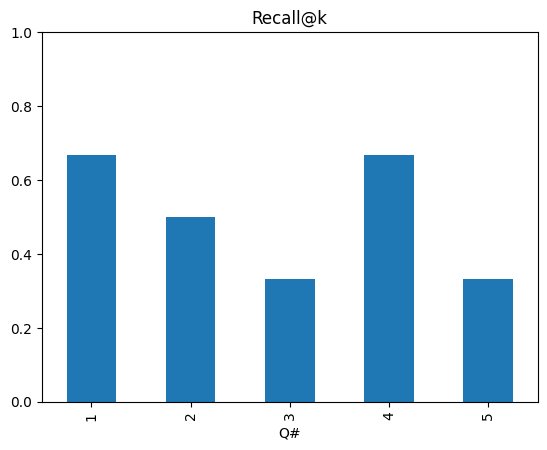

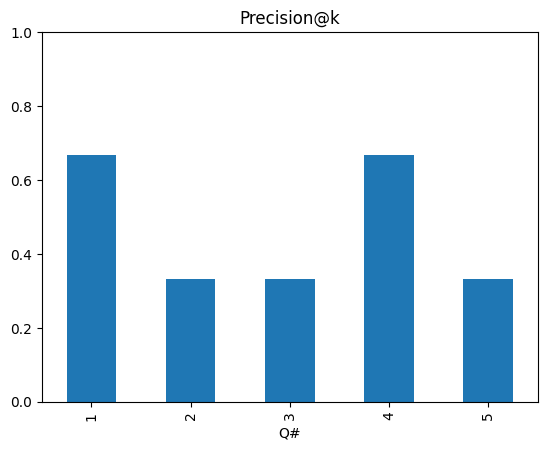

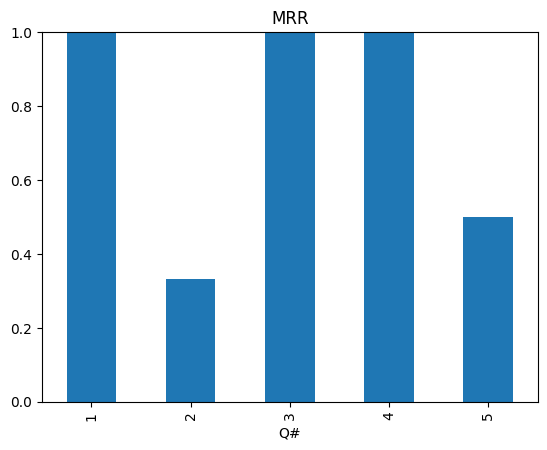

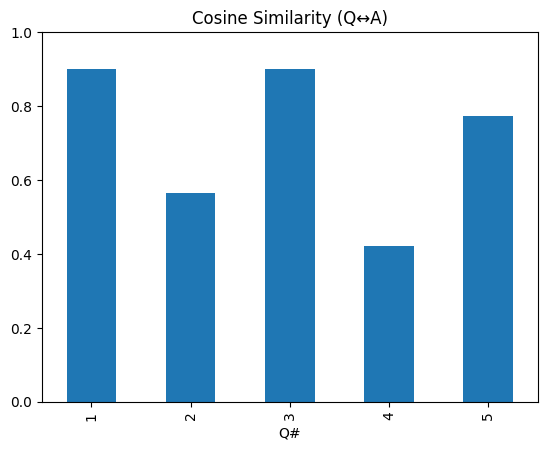

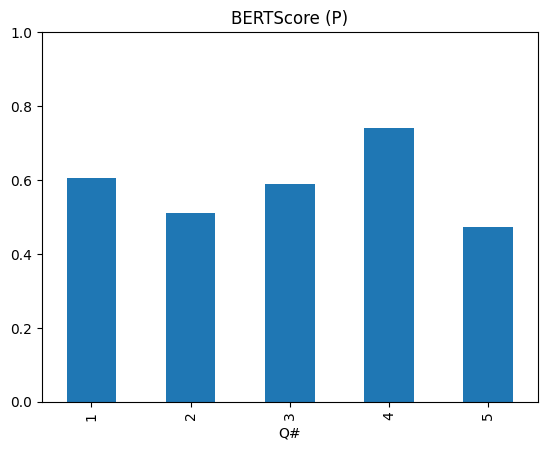

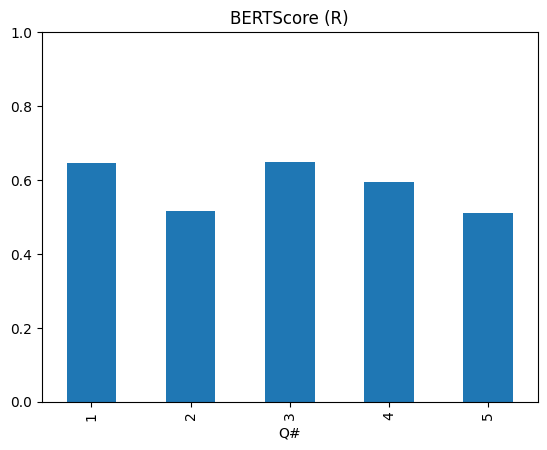

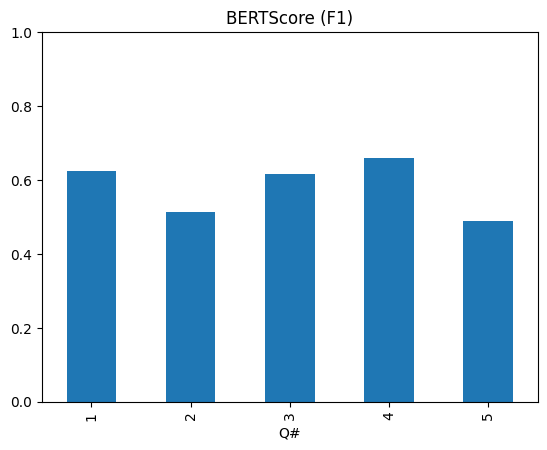

In [36]:
import matplotlib.pyplot as plt
for col in traditional_df.columns[1:]:
    traditional_df.plot.bar(x="Q#", y=col, legend=False, title=col)
    plt.ylim(0, 1)
    plt.show()


## RESULT

### DeepEval

DeepEval offers a strong combination of usability and metric coverage. It provides a broad range of traditional and semantic evaluation metrics through a clean, intuitive API. This makes it a practical choice for teams aiming to perform general-purpose evaluation with minimal configuration. It is good for early experimentation and development.

### RAGAS

RAGAS is specifically designed for evaluating RAG pipelines and stands out for its specialized and custom metrics, particularly around **faithfulness** and **context grounding**. It supports synthetic dataset generation, which is useful for testing in scenarios where labeled data is limited. While the tool offers in-depth evaluation capabilities, it requires some technical understanding to fully leverage its potential.

### TruLens

TruLens emphasizes ease of integration and simplicity in setup. It allows quick feedback on model behavior, which can be helpful during prototyping. However, its evaluation depth is relatively limited, and its results may lack the granularity necessary for detailed analysis or fine-tuning. It is better suited for lightweight use cases where evaluation requirements are less demanding.

### Arize Phoenix

Arize Phoenix is well-suited for production environments where **real-time monitoring** and **manual evaluation** are priorities. It includes a built-in dashboard for continuous tracking of RAG system behavior, offering visibility into model performance over time. While it does not focus heavily on automated scoring, it excels in operational monitoring and human-in-the-loop analysis.


The preferred framework depends on the application context:

 - For in-depth RAG evaluation and model refinement, RAGAS is recommended due to its tailored metrics and synthetic data capabilities.

 - For quick-start experiments and broad metric coverage, DeepEval is ideal.

 - For production monitoring and observability, Arize Phoenix is the most suitable, offering user friendly UI tools and manual evaluation workflows.

 - TruLens, while easy to integrate, is best reserved for lightweight use cases with minimal evaluation needs.